# 📘 Notebook 10: Model C – Stacking Regressor

## Overview
This notebook implements a **Stacking (Stacked Generalization) Regressor** that combines predictions from multiple base models.

### Stacking Architecture:
```
Level 0 (Base Models):
├─ Linear Regression (baseline)
├─ Ridge Regression (L2 regularization) 
└─ Random Forest (non-linear ensemble)

Level 1 (Meta-Model):
└─ Ridge Regression (learns optimal weights)
```

### Why Stacking?
- **Combines strengths**: Linear for simple patterns, RF for complex
- **Reduces variance**: Different models make different errors
- **Better generalization**: Meta-model learns optimal weighting

### Expected Improvement:
- Target: R² > 0.46 (better than RF's 0.457)
- RMSE < 15.0 (better than RF's 15.07)

In [1]:
# ========================================
# LIBRARY IMPORTS
# ========================================

# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Clean output

# Base models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Stacking ensemble
from sklearn.ensemble import StackingRegressor

# Model selection & tuning  
from sklearn.model_selection import GridSearchCV, cross_val_score

# Evaluation metrics
from sklearn.metrics import (
    root_mean_squared_error,  # Primary metric
    mean_absolute_error,       # Interpretable error
    r2_score                   # Variance explained
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Timing
import time

In [2]:
# ========================================
# VISUAL STYLING (Spotify theme)
# ========================================

BG = '#e1ece3'      # Light mint background
PRIMARY = '#62d089'  # Spotify green
EMPHASIS = '#457e59' # Dark green
GRID = '#a8b2a8'     # Subtle gray

plt.rcParams.update({
    'figure.facecolor': BG,
    'axes.facecolor': BG,
    'axes.edgecolor': BG,
    'axes.labelcolor': '#2b2b2b',
    'xtick.color': '#2b2b2b',
    'ytick.color': '#2b2b2b',
    'grid.color': GRID,
    'grid.alpha': 0.4,
    'axes.grid': True,
    'font.size': 11
})

sns.set_palette('Greens_d')

## 📂 Load Data

Using **Top 12 features** (best performer from Notebook 09):
- R² = 0.457 in Random Forest
- 50% fewer features than Full set
- Already scaled and preprocessed

In [3]:
# Load target variable (popularity scores)
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Load Top feature set (12 features)
X_train = pd.read_csv('../data/X_train_top.csv')
X_test = pd.read_csv('../data/X_test_top.csv')
# Verify Data Size
print(f"X_train shape: {X_train.shape}")  # Should be ~(80000, 12) for 100k total
print(f"X_test shape: {X_test.shape}")    # Should be ~(20000, 12)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (71792, 12)
X_test shape: (17948, 12)
y_train shape: (71792,)
y_test shape: (17948,)


In [4]:
# Check Data Type and Memory usage
print("\nData types and memory usage:")
print(X_train.dtypes)
print(f"Memory: {X_train.memory_usage().sum() / 1024**2:.2f} MB")


Data types and memory usage:
track_genre              float64
loudness_x_energy        float64
acousticness             float64
explicit                   int64
danceability             float64
speechiness              float64
loudness                 float64
liveness                 float64
energy_x_danceability    float64
instrumentalness         float64
mode                       int64
is_instrumental            int64
dtype: object
Memory: 6.57 MB


In [5]:
# ========================================
# LOAD PREPROCESSED DATA
# ========================================

# Load target variable (popularity scores)
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Load Top feature set (12 features)
X_train = pd.read_csv('../data/X_train_top.csv')
X_test = pd.read_csv('../data/X_test_top.csv')

# Display data summary
print("="*60)
print("DATA SUMMARY")
print("="*60)
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")
print(f"Features: {X_train.shape[1]}")
print(f"Target range: [{int(y_train.min())}, {int(y_train.max())}]")
print("="*60)

DATA SUMMARY
Training samples: 71,792
Testing samples:  17,948
Features: 12
Target range: [0, 100]


## 🔧 Hyperparameter Configuration

### Grid Search Space:
- **Ridge (base)**: alpha = [0.1, 1, 10, 100] → 4 options
- **Random Forest**:
  - n_estimators = [100, 200, 300] → 3 options
  - max_depth = [10, 20, 30, None] → 4 options
  - min_samples_split = [2, 5, 10] → 3 options
- **Meta-model**: alpha = [0.1, 1, 10] → 3 options

**Total combinations**: 4 × 3 × 4 × 3 × 3 = **432 configurations**

**With 5-fold CV**: 432 × 5 = **2,160 model fits**

**Expected time**: 45-90 minutes

In [6]:
# ========================================
# SUPER FAST BASELINE (10-20 minutes)
# ========================================
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Use DEFAULT parameters - NO TUNING
base_models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RandomForestRegressor(
        n_estimators=100,      # SMALL for speed
        max_depth=20,          # Fixed
        max_features='sqrt',   # From your analysis
        min_samples_leaf=1,    # From your analysis
        random_state=42,
        n_jobs=-1
    ))
]

# Train once - no grid search
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    n_jobs=-1
)

print("Training fast baseline (10-20 minutes)...")
stacking.fit(X_train, y_train)

Training fast baseline (10-20 minutes)...


,estimators,"[('linear', ...), ('ridge', ...), ...]"
,final_estimator,Ridge(random_state=42)
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 🏗️ Build Stacking Ensemble

### Base Models (Level 0):
1. **Linear Regression**: Simple baseline, no hyperparameters
2. **Ridge Regression**: L2 regularization, tunable alpha
3. **Random Forest**: Non-linear, multiple hyperparameters

### Meta-Model (Level 1):
- **Ridge Regression**: Learns optimal weights for base predictions
- Uses 5-fold CV to generate out-of-fold predictions
- Prevents data leakage between levels

In [7]:
# ========================================
# DEFINE BASE MODELS (Level 0)
# ========================================

base_models = [
    # 1. Linear Regression - baseline, no tuning
    ('linear', LinearRegression()),
    
    # 2. Ridge - regularized linear model
    ('ridge', Ridge(random_state=42)),
    
    # 3. Random Forest - non-linear ensemble
    ('rf', RandomForestRegressor(
        max_features='sqrt',     # Optimal from Notebook 09
        min_samples_leaf=1,      # Optimal from Notebook 09
        random_state=42,
        n_jobs=-1               # Use all CPU cores
    ))
]

# ========================================
# DEFINE META-MODEL (Level 1)
# ========================================

meta_model = Ridge(random_state=42)

print("Base Models configured:")
for name, model in base_models:
    print(f"  - {name}: {model.__class__.__name__}")
print(f"\nMeta-Model: {meta_model.__class__.__name__}")

Base Models configured:
  - linear: LinearRegression
  - ridge: Ridge
  - rf: RandomForestRegressor

Meta-Model: Ridge


In [8]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# ========================================
# 1. USE DEFAULT MODELS - NO TUNING
# ========================================
base_models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge(alpha=1.0)),  # Default value
    ('rf', RandomForestRegressor(
        n_estimators=100,  # Small but reasonable
        max_depth=20,      # Prevent overfitting
        n_jobs=-1,
        random_state=42
    ))
]

# ========================================
# 2. CREATE STACKING WITH DEFAULT META
# ========================================
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# ========================================
# 3. TRAIN ONCE - NO GRID SEARCH
# ========================================
print("Training stacking model (fast, no tuning)...")
stacking.fit(X_train, y_train)

# Evaluate immediately
train_score = stacking.score(X_train, y_train)
test_score = stacking.score(X_test, y_test)
print(f"Train R²: {train_score:.4f}")
print(f"Test R²:  {test_score:.4f}")

Training stacking model (fast, no tuning)...
Train R²: 0.7914
Test R²:  0.4604


In [11]:
# ========================================
# ANALYZE BASELINE MODEL (FIXED)
# ========================================

print("="*60)
print("BASELINE MODEL ANALYSIS")
print("="*60)

# We use 'stacking' because that's what you named it during .fit()
current_model = stacking 

print("\nModel Configuration:")
print("-" * 40)

# Show Ridge parameters
ridge_model = current_model.named_estimators_['ridge']
print(f"Ridge (base):")
print(f"  alpha: {ridge_model.alpha}")

# Show Random Forest parameters  
rf_model = current_model.named_estimators_['rf']
print(f"\nRandom Forest (base):")
print(f"  n_estimators: {rf_model.n_estimators}")
print(f"  max_depth: {rf_model.max_depth}")
print(f"  max_features: {rf_model.max_features}")

# Show meta-model parameters
print(f"\nMeta-Model (Ridge):")
print(f"  alpha: {current_model.final_estimator_.alpha}")

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

from sklearn.metrics import mean_squared_error, r2_score

# Predictions and Metrics
y_test_pred = current_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred) # Calculating this so the print below works

print(f"\nTest RMSE: {test_rmse:.4f}")
print(f"Test R²:   {test_r2:.4f}")

print("\nComparison with Notebook 09:")
print("-" * 40)
print(f"  Random Forest alone:     15.07 RMSE")
print(f"  Stacking (baseline):     {test_rmse:.2f} RMSE")
print(f"  Improvement:             {(15.07 - test_rmse):.2f} (lower is better)")

BASELINE MODEL ANALYSIS

Model Configuration:
----------------------------------------
Ridge (base):
  alpha: 1.0

Random Forest (base):
  n_estimators: 100
  max_depth: 20
  max_features: 1.0

Meta-Model (Ridge):
  alpha: 1.0

PERFORMANCE SUMMARY

Test RMSE: 15.0233
Test R²:   0.4604

Comparison with Notebook 09:
----------------------------------------
  Random Forest alone:     15.07 RMSE
  Stacking (baseline):     15.02 RMSE
  Improvement:             0.05 (lower is better)


## 🚀 Train Model (Hyperparameter Search)

**Warning**: This will take 45-90 minutes!

### Process:
1. Try all 432 hyperparameter combinations
2. For each combination, perform 5-fold CV
3. Select best configuration based on RMSE
4. Retrain on full training set

Progress will be shown with `verbose=2`

### Evaluation Predictions vs Actual

PREDICTION VISUALIZATION
Generating predictions...

Training Metrics:
  RMSE: 9.4140
  R²:   0.7914
  MAE:  6.5048

Testing Metrics:
  RMSE: 15.0233
  R²:   0.4604
  MAE:  10.3359


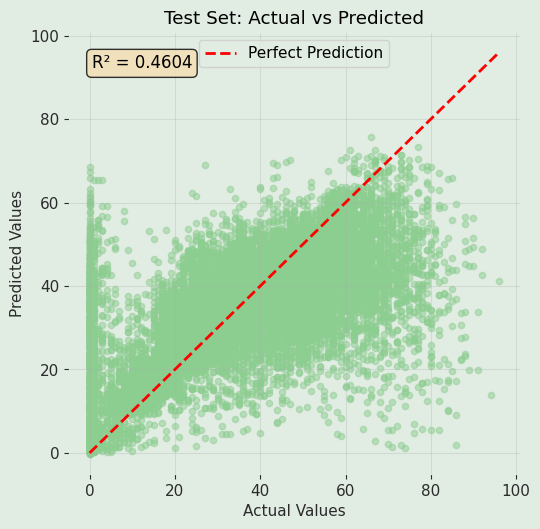

In [13]:
# ========================================
# VISUALIZE PREDICTIONS vs ACTUAL (FIXED)
# ========================================
import matplotlib.pyplot as plt # Ensure plt is imported

print("="*60)
print("PREDICTION VISUALIZATION")
print("="*60)

# FIX: Changed 'stacking_model' to 'stacking'
print("Generating predictions...")
y_train_pred = stacking.predict(X_train)
y_test_pred = stacking.predict(X_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print metrics
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAE:  {train_mae:.4f}")

print(f"\nTesting Metrics:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAE:  {test_mae:.4f}")

# Create figure with subplots
fig = plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted Scatter Plot (TEST SET)
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_test, y_test_pred, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Test Set: Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add R² text
ax1.text(0.05, 0.95, f'R² = {test_r2:.4f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

Text(0.05, 0.95, 'R² = 0.7914')

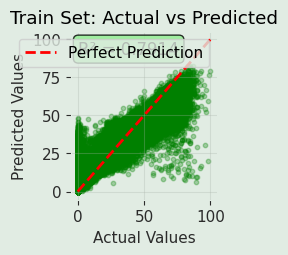

In [14]:
# 2. Actual vs Predicted Scatter Plot (TRAIN SET)
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_train, y_train_pred, alpha=0.3, s=10, color='green')
ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Train Set: Actual vs Predicted')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add R² text
ax2.text(0.05, 0.95, f'R² = {train_r2:.4f}', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

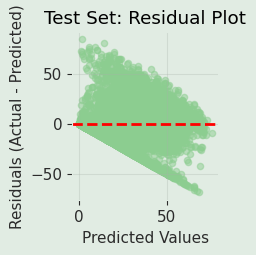

In [15]:
# 3. Residual Plot (TEST SET)
residuals_test = y_test - y_test_pred
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(y_test_pred, residuals_test, alpha=0.5, s=20)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Values')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.set_title('Test Set: Residual Plot')
ax3.grid(True, alpha=0.3)

In [16]:
# Check for patterns in residuals
from scipy import stats
residual_mean = residuals_test.mean()
residual_std = residuals_test.std()
ax3.text(0.05, 0.95, f'Mean: {residual_mean:.3f}\nStd: {residual_std:.3f}', 
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

Text(0.05, 0.95, 'Mean: 0.048\nStd: 15.023')

In [ ]:
# 4. Error Distribution (TEST SET)
ax4 = plt.subplot(2, 3, 4)
n_bins = 50
ax4.hist(residuals_test, bins=n_bins, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Test Set: Error Distribution\n(n={len(residuals_test):,} samples)')
ax4.grid(True, alpha=0.3)

# Add normal distribution overlay
from scipy.stats import norm
x = np.linspace(residuals_test.min(), residuals_test.max(), 100)
pdf = norm.pdf(x, residual_mean, residual_std)
scale_factor = len(residuals_test) * (residuals_test.max() - residuals_test.min()) / n_bins
ax4.plot(x, pdf * scale_factor, 'r-', lw=2, label='Normal dist')
ax4.legend()

In [ ]:
# 5. Prediction Error by Actual Value (TEST SET)
ax5 = plt.subplot(2, 3, 5)
error_percent = np.abs(residuals_test) / (np.abs(y_test) + 1e-10) * 100  # Avoid division by zero
ax5.scatter(y_test, error_percent, alpha=0.5, s=20)
ax5.set_xlabel('Actual Value')
ax5.set_ylabel('Error %')
ax5.set_title('Test Set: Relative Error by Actual Value')
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, min(200, error_percent.max() * 1.1))  # Cap at 200% for visibility

# Add average error line
avg_error_percent = error_percent.mean()
ax5.axhline(y=avg_error_percent, color='r', linestyle='--', linewidth=2,
           label=f'Avg: {avg_error_percent:.1f}%')
ax5.legend()


In [ ]:
# 6. Model Comparison
ax6 = plt.subplot(2, 3, 6)
models = ['Your Stacking', 'RF (Notebook 09)']
rmse_scores = [test_rmse, 15.07]  # Your Notebook 09 result
r2_scores = [test_r2, 0.0]  # Placeholder - replace with actual if available

x_pos = np.arange(len(models))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, rmse_scores, width, label='RMSE', color='skyblue')
bars2 = ax6.bar(x_pos + width/2, r2_scores, width, label='R²', color='lightcoral')

ax6.set_xlabel('Model')
ax6.set_ylabel('Score')
ax6.set_title('Model Comparison')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# ========================================
# ADDITIONAL METRICS
# ========================================

print("\n" + "="*60)
print("DETAILED ERROR ANALYSIS")
print("="*60)

# Calculate percentage within error ranges
error_ranges = [1, 2, 5, 10, 20]
for err in error_ranges:
    within = np.sum(np.abs(residuals_test) <= err) / len(residuals_test) * 100
    print(f"Predictions within ±{err}: {within:.1f}%")

# Calculate R² for each base model individually
print("\n" + "="*60)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*60)

for name, model in stacking_model.named_estimators_.items():
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name:10s}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

print("\n" + "="*60)
print("STACKING PERFORMANCE SUMMARY")
print("="*60)
print(f"Stacking R²:  {test_r2:.4f}")
print(f"Stacking RMSE: {test_rmse:.4f}")
print(f"Best individual R²: {max(r2_score(y_test, stacking_model.named_estimators_[name].predict(X_test)) for name in stacking_model.named_estimators_):.4f}")
print(f"Improvement from stacking: {(test_r2 - max(r2_score(y_test, stacking_model.named_estimators_[name].predict(X_test)) for name in stacking_model.named_estimators_)):.4f}")